# FINAL Meteo 203 Lab Exercise
## Investigating the Onset of the 1997–1998 El Niño: A Zonal Wind and SST Anomaly Analysis  
---

Step 1: Data Preparation
1. Download ERA5 or GFS FNL NetCDF data (monthly resolution)
2. Suggested variables: u10, sst
3. Clip to Pacific region (lon: 120–280 or -160 to 80; lat: -30 to 30) to make processing faster

In [3]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.geodesic import Geodesic
from shapely.geometry import box
import netCDF4 as nc

In [5]:
file_path = 'FINAL_DATA.nc'
ds = xr.open_dataset(file_path)

In [6]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 1020, latitude: 241, longitude: 961)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
  * latitude    (latitude) float64 2kB 30.0 29.75 29.5 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 8kB -160.0 -159.8 -159.5 ... 79.5 79.75 80.0
    expver      (valid_time) <U4 16kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 945MB ...
    sst         (valid_time, latitude, longitude) float32 945MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-09T07:09 GRIB to CDM+CF via cfgrib-0.9.1...

Step 2: Determine Climatological Normal
1. Group by month or season (e.g., groupby('valid_time.month'))
2. Calculate the long-term mean for each month or season. You can refer to your old notebooks.

In [11]:
sst = ds['sst']

In [12]:
sst

<xarray.DataArray 'sst' (valid_time: 1020, latitude: 241, longitude: 961)> Size: 945MB
[236233020 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
  * latitude    (latitude) float64 2kB 30.0 29.75 29.5 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 8kB -160.0 -159.8 -159.5 ... 79.5 79.75 80.0
    expver      (valid_time) <U4 16kB ...
Attributes: (12/31)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      231601
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

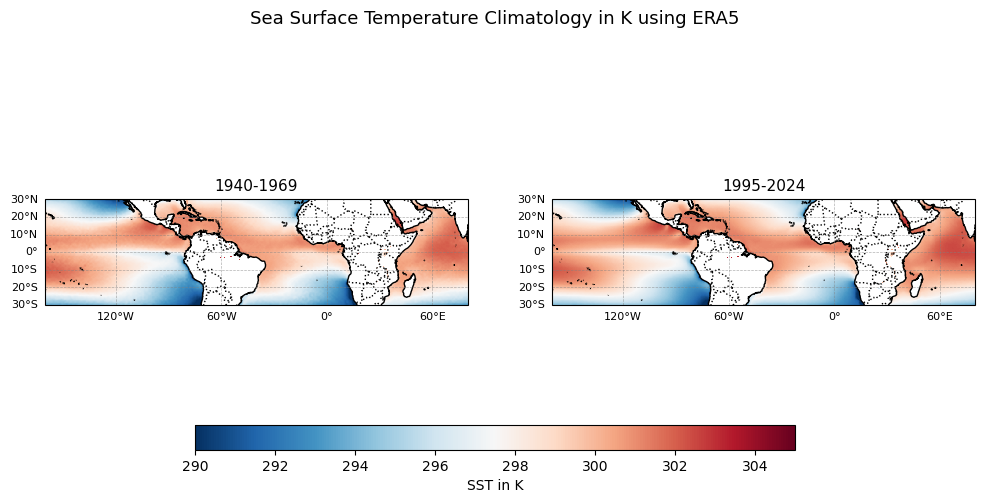

In [67]:
# Comparison of Previous Climate Normal to Latest Climate Normal
sst_clim_1 = sst.sel(valid_time=slice("1940", "1969")).mean(dim="valid_time")
sst_clim_2 = sst.sel(valid_time=slice("1995", "2024")).mean(dim="valid_time")

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    1, 2, figsize=(12,5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ax, data, title in zip(
    axes,
    [sst_clim_1, sst_clim_2],
    ["1940-1969", "1995-2024"]
):
    pcm = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        vmin=290, vmax=305, add_colorbar=False
    )
    
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title, fontsize=11)

    # ---- LATITUDE & LONGITUDE LABELS ----
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.6,
        linestyle='--'
    )
    gl.top_labels = False       # no labels at top
    gl.right_labels = False     # no labels at right
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# Shared colorbar below both subplots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.05])
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="SST in K")

plt.suptitle("Sea Surface Temperature Climatology in K using ERA5", fontsize=13, y=0.98)

plt.show()

The Climatological Sea Surface Temperature of 1940 to 1969 and 1995 to 2024
Figures above show two (2) different climatological normal. The 1940 to 1969 on the left and the 1995 to 2024 in the right. As for the patterns of variation, almost the same patterns can be observed on both plots, but the areas affected by warming is higher on the latter years compared to the firt climate normal. More warmer is also observed in the latter years and can this warming can be associated with climate change, as changes in SST is one of the criteria for climate change. It has been also found out and observed in the plots that lower latitudes tends to have a higher SST compared to those area in higher latitudes, and this is due to the position (tilt) of the eart. The maximum solar radiation is on this region that results to surplus of energy.

In [73]:
# Monthly Climatology for SST (will be using the latest ALL years)
sst_monthly_clim_all = ds["sst"].groupby("valid_time.month").mean("valid_time")

# Seasonal SST (ALL years)
sst_JFM = sst_monthly_clim_all.sel(month=[1,2,3]).mean("month")
sst_AMJ = sst_monthly_clim_all.sel(month=[4,5,6]).mean("month")
sst_JAS = sst_monthly_clim_all.sel(month=[7,8,9]).mean("month")
sst_OND = sst_monthly_clim_all.sel(month=[10,11,12]).mean("month")

In [74]:
#Seasonal SST for 1997
def seasonal_mean(ds, months):
    return ds.sel(valid_time=ds.valid_time.dt.month.isin(months)).mean("valid_time")

sst_1997 = sst.sel(valid_time="1997")

sst_anom_1997_JFM = seasonal_mean(sst_1997, [1,2,3])
sst_anom_1997_AMJ = seasonal_mean(sst_1997, [4,5,6])
sst_anom_1997_JAS = seasonal_mean(sst_1997, [7,8,9])
sst_anom_1997_OND = seasonal_mean(sst_1997, [10,11,12])

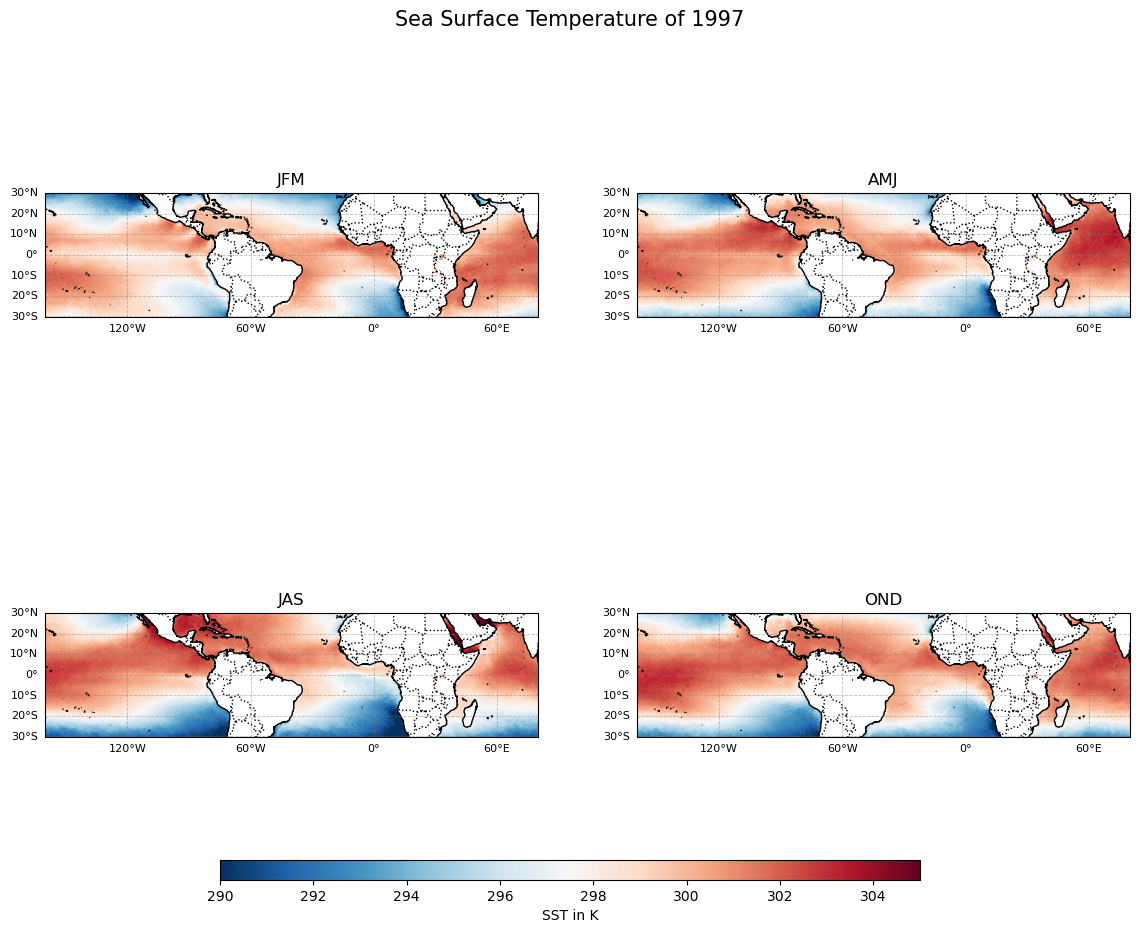

In [92]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    2, 2, figsize=(14, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

axes = axes.flatten()

for ax, data, title in zip(
    axes,
    [sst_anom_1997_JFM, sst_anom_1997_AMJ, sst_anom_1997_JAS, sst_anom_1997_OND],
    ["JFM", "AMJ", "JAS", "OND"]
):
    pcm = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        vmin=290, vmax=305, add_colorbar=False
    )
    
    # Coastlines and borders
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title, fontsize=12)
    
    # ---- LATITUDE & LONGITUDE ----
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.6,
        color='gray',
        alpha=0.5,
        linestyle='--'
    )
    gl.top_labels = False     # Do not label on top
    gl.right_labels = False   # Do not label on right
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# ---- Shared colorbar ----
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="SST in K")

plt.suptitle("Sea Surface Temperature of 1997", fontsize=15, y=0.95)

plt.show()

1997 Sea Surface Temperature: The Great El Nino
The 1997-1998 El Nino was one of the worst El Nino that hits the world and Philippines was no exemption on it. It is categorized as very strong El Nino and devastated the world for its effects such as drought and consequently damaged the life of people especially the farmers. If we try to observe and analyze the plots during different seasons, warming in the different parts of the world is very obvious in the different seasons, and the warmest season was observed during JAS and OND where the peaks of ENSO is felt and observed.

In [75]:
# Computation of Anomaly
sst_anom_JFM = sst_anom_1997_JFM - sst_JFM
sst_anom_AMJ = sst_anom_1997_AMJ - sst_AMJ
sst_anom_JAS = sst_anom_1997_JAS - sst_JAS
sst_anom_OND = sst_anom_1997_OND - sst_OND

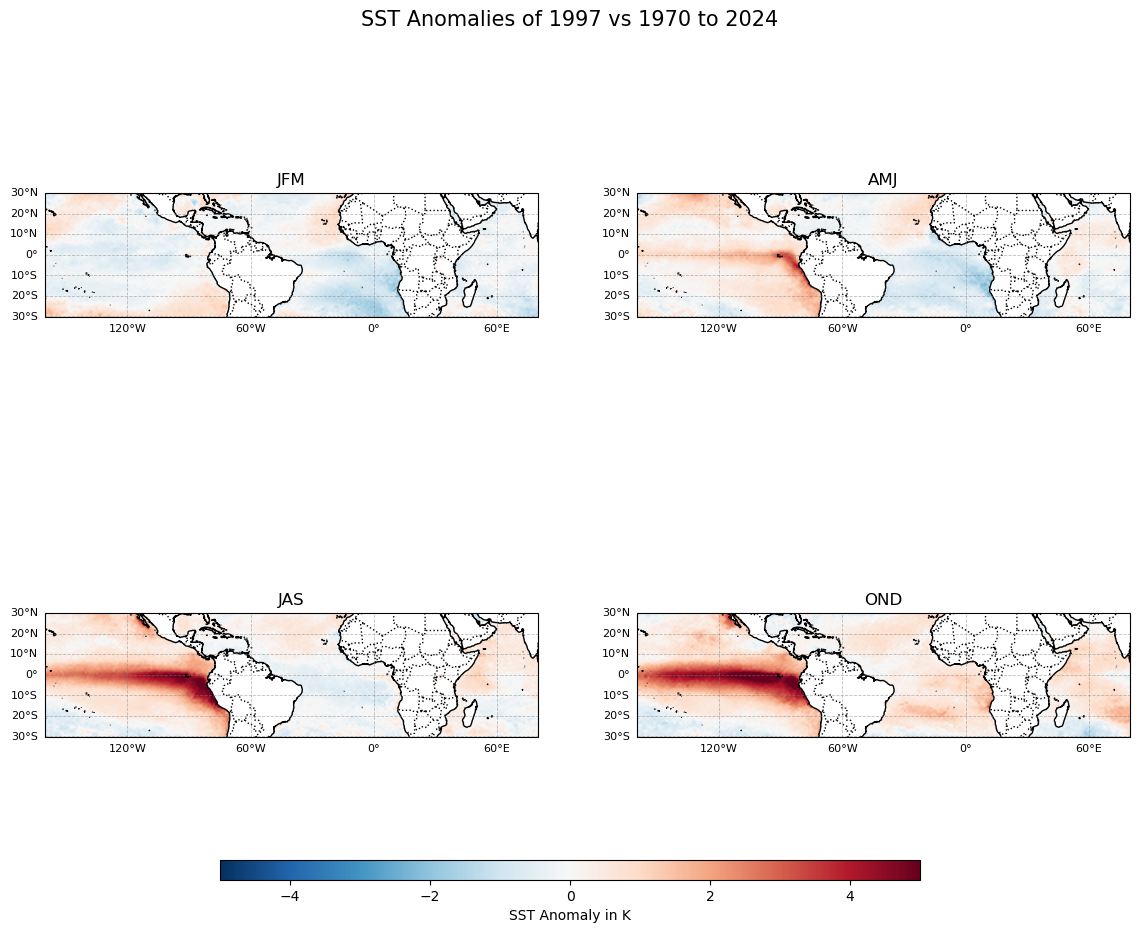

In [89]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    2, 2, figsize=(14, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

axes = axes.flatten()

for ax, data, title in zip(
    axes,
    [sst_anom_JFM, sst_anom_AMJ, sst_anom_JAS, sst_anom_OND],
    ["JFM", "AMJ", "JAS", "OND"]
):
    pcm = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        vmin=-5, vmax=5, add_colorbar=False
    )
    
    # Coastlines and borders
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title, fontsize=12)

    # ---- LATITUDE & LONGITUDE ----
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.6,
        color='gray',
        alpha=0.5,
        linestyle='--'
    )
    gl.top_labels = False     # Do not label on top
    gl.right_labels = False   # Do not label on right
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# ---- Shared colorbar ----
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="SST Anomaly in K")

plt.suptitle("SST Anomalies of 1997 vs 1970 to 2024", fontsize=15, y=0.95)

plt.show()

SST Anomaly of 1997 El Nino vs 1970 to 2024
To determine how high or low the changed from its normal values, anomaly had been done. Greatest anomaly had been observed in the Pacific just at the right of mainland of South America. A line of anomalous positive SST along the equator and greatest during the OND as this is the peak of ENSO events. It started to develop during AMJ, grows during JAS season and a full blown warm phase of ENSO had been observed during OND Season.

In [77]:
u10 = ds['u10']

In [78]:
u10

<xarray.DataArray 'u10' (valid_time: 1020, latitude: 241, longitude: 961)> Size: 945MB
[236233020 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
  * latitude    (latitude) float64 2kB 30.0 29.75 29.5 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 8kB -160.0 -159.8 -159.5 ... 79.5 79.75 80.0
    expver      (valid_time) <U4 16kB ...
Attributes: (12/32)
    GRIB_paramId:                             165
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      231601
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown
    GRIB_surface:                             0.0

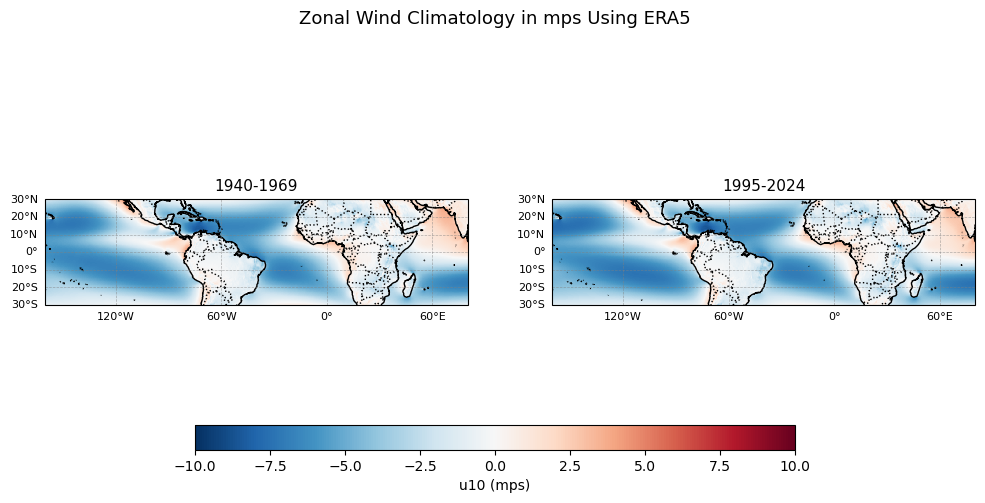

In [81]:
# Comparison of Previous Climate Normal to Latest Climate Normal
u10_clim_1 = u10.sel(valid_time=slice("1940", "1969")).mean(dim="valid_time")
u10_clim_2 = u10.sel(valid_time=slice("1995", "2024")).mean(dim="valid_time")

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    1, 2, figsize=(12,5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ax, data, title in zip(
    axes,
    [u10_clim_1, u10_clim_2],
    ["1940-1969", "1995-2024"]
):
    pcm = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        vmin=-10, vmax=10, add_colorbar=False
    )

    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title, fontsize=11)

    # ---- LATITUDE & LONGITUDE LABELS ----
    gl = ax.gridlines(
        draw_labels=True,
        crs=ccrs.PlateCarree(),
        linewidth=0.5,
        color='gray',
        alpha=0.6,
        linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# Shared colorbar
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.05])
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="u10 (mps)")

plt.suptitle("Zonal Wind Climatology in mps Using ERA5", fontsize=13, y=0.98)

plt.show()

Climatology of Zonal Wind
The images above showed two different climatology for Zonal Winds, the earlier climatology from 1940 ti 1969 and the latest climatology from 1995 to 2024 in meters per second using ERA 5. As shown in the images, there were more strong westerly winds compared to easterly wind flow and this is due to the location. Westerly winds are more dominant from the equator to tropical regions leading the winds to blow on the west.

In [82]:
# Monthly Climatology for Zonal Winds (will be using the latest ALL years)
u10_monthly_clim_all = ds["u10"].groupby("valid_time.month").mean("valid_time")

# Seasonal Zonal (ALL years)
u10_JFM = u10_monthly_clim_all.sel(month=[1,2,3]).mean("month")
u10_AMJ = u10_monthly_clim_all.sel(month=[4,5,6]).mean("month")
u10_JAS = u10_monthly_clim_all.sel(month=[7,8,9]).mean("month")
u10_OND = u10_monthly_clim_all.sel(month=[10,11,12]).mean("month")

In [83]:
#Seasonal Zonal Winds for 1997
def seasonal_mean(ds, months):
    return ds.sel(valid_time=ds.valid_time.dt.month.isin(months)).mean("valid_time")

u10_1997 = u10.sel(valid_time="1997")

u10_anom_1997_JFM = seasonal_mean(u10_1997, [1,2,3])
u10_anom_1997_AMJ = seasonal_mean(u10_1997, [4,5,6])
u10_anom_1997_JAS = seasonal_mean(u10_1997, [7,8,9])
u10_anom_1997_OND = seasonal_mean(u10_1997, [10,11,12])

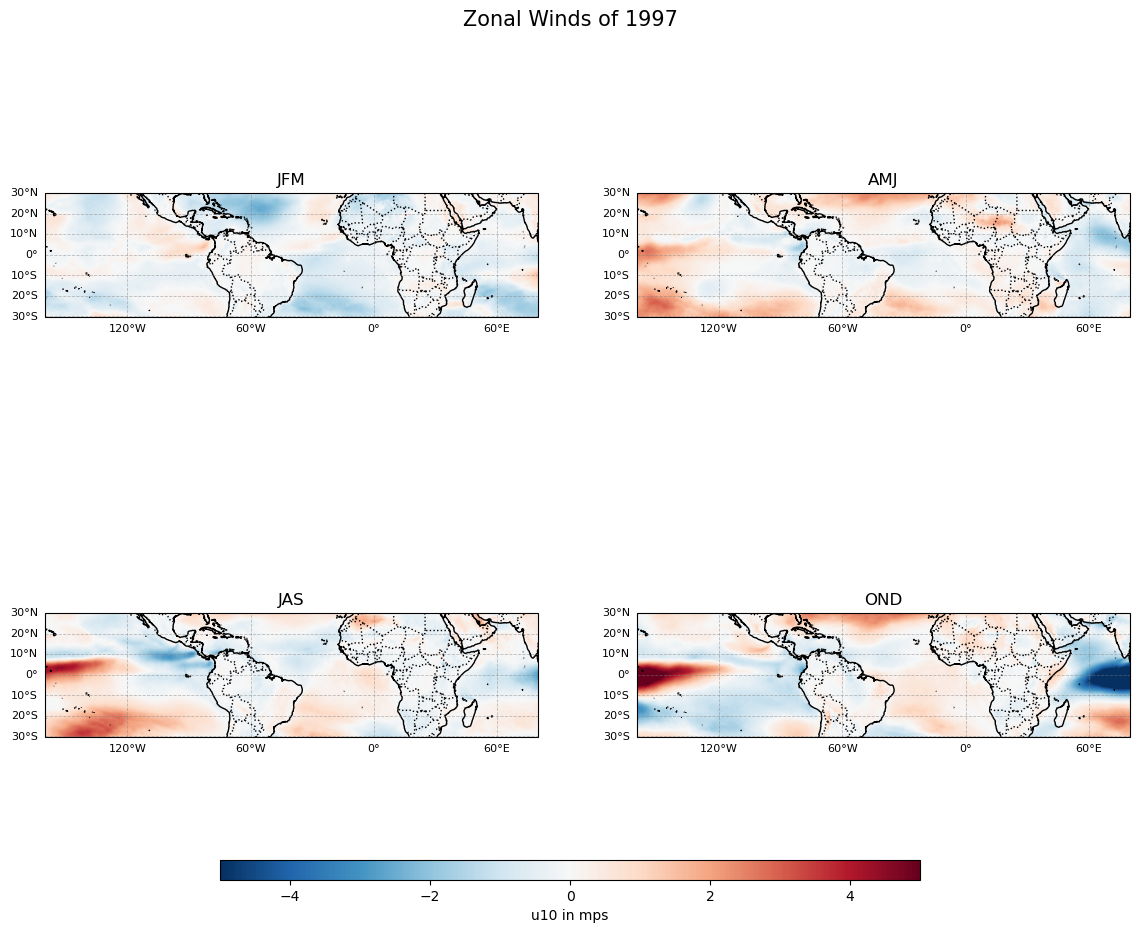

In [93]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    2, 2, figsize=(14, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

axes = axes.flatten()

for ax, data, title in zip(
    axes,
    [u10_anom_JFM, u10_anom_AMJ, u10_anom_JAS, u10_anom_OND],
    ["JFM", "AMJ", "JAS", "OND"]
):
    pcm = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        vmin=-5, vmax=5, add_colorbar=False
    )
    
    # Coastlines and borders
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title, fontsize=12)

 # ---- LATITUDE & LONGITUDE ----
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.6,
        color='gray',
        alpha=0.5,
        linestyle='--'
    )
    gl.top_labels = False     # Do not label on top
    gl.right_labels = False   # Do not label on right
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

# ---- Shared colorbar ----
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="u10 in mps")

plt.suptitle("Zonal Winds of 1997", fontsize=15, y=0.95)

plt.show()

Zonal Winds During the 1997 El Nino
The figures above shows the seasonal zonal winds during the 1997 El Nino. As shown, the highest magnitude of wind can be observed during the OND Season, where the peak of El Nino can be felt. A strong easterly winds in the Indian Ocean while a stong westerly winds in the Pacific Ocean. Though there were prominent strong easterly winds during the JAS Season, the magnitude of strong easterly winds is felt during OND.

In [84]:
# Computation of Anomaly
u10_anom_JFM = u10_anom_1997_JFM - u10_JFM
u10_anom_AMJ = u10_anom_1997_AMJ - u10_AMJ
u10_anom_JAS = u10_anom_1997_JAS - u10_JAS
u10_anom_OND = u10_anom_1997_OND - u10_OND

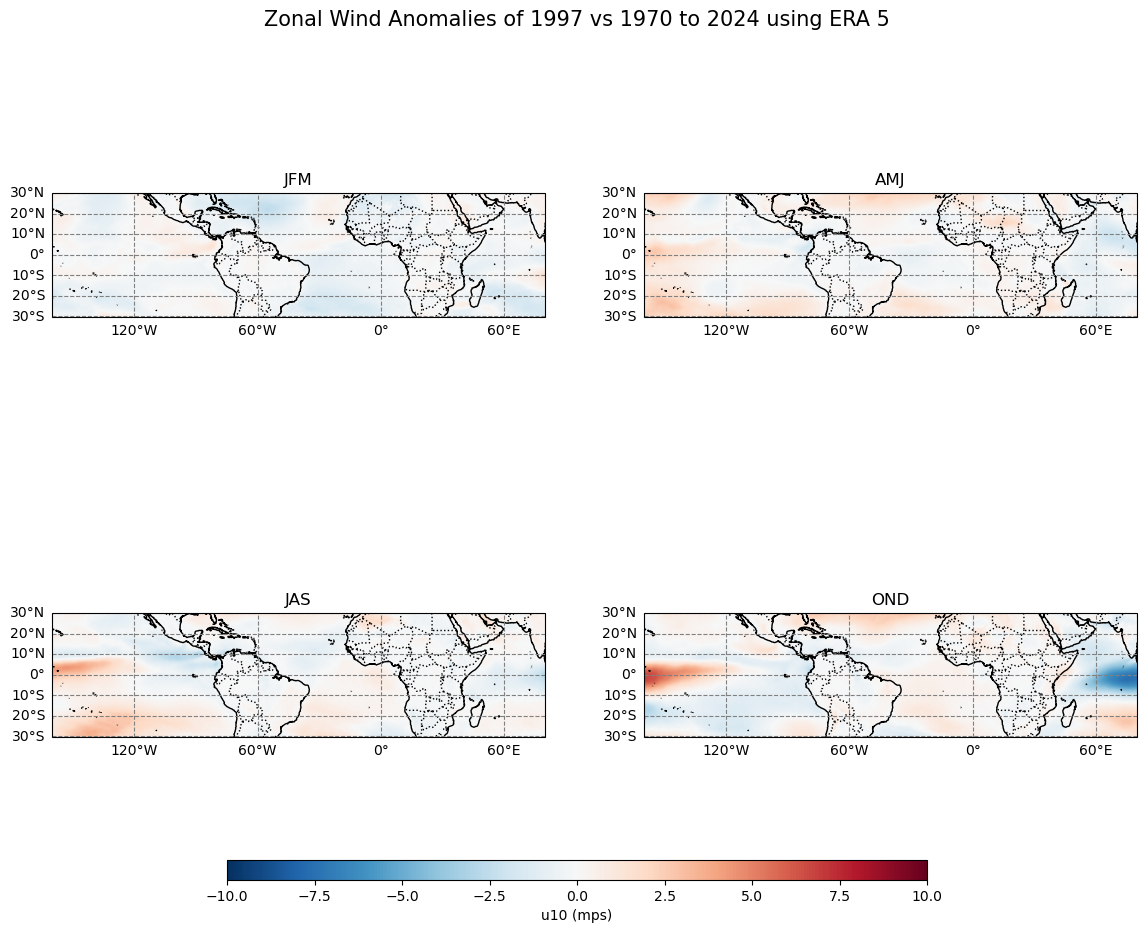

In [88]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(
    2, 2, figsize=(14, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

axes = axes.flatten()  

for ax, data, title in zip(
    axes,
    [u10_anom_JFM, u10_anom_AMJ, u10_anom_JAS, u10_anom_OND],
    ["JFM", "AMJ", "JAS", "OND"]
):
    pcm = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        vmin=-10, vmax=10, add_colorbar=False
    )

    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title, fontsize=12)

    # 🔹 Add latitude/longitude gridlines
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.8, linestyle="--", color="gray"
    )
    gl.top_labels = False   # Turn off top labels
    gl.right_labels = False # Turn off right labels

# ---- Shared colorbar ----
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal",
             label="u10 (mps)")

plt.suptitle("Zonal Wind Anomalies of 1997 vs 1970 to 2024 using ERA 5", fontsize=15, y=0.95)
plt.show()

Deadline: 10 December 2025.

### Context
The 1997–1998 El Niño event is one of the strongest on record. Several studies suggest that it was triggered in part by a [strong and sustained Westerly Wind Burst (WWB) in the equatorial Pacific.](https://journals.ametsoc.org/view/journals/clim/34/20/JCLI-D-21-0010.1.xml) In this project, you will explore this by looking at anomalies in zonal wind (u10) and sea surface temperature (SST) across the Pacific Ocean.

### Objectives 
You are tasked to:
1. Download *monthly* [ERA5](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means) or [NCEP/NCAR Reanalysis](https://gdex.ucar.edu/datasets/d090002/) reanalysis data containing u10 and sst. It is up to you to establish your climatologies (suggested: 1950-1996).
    1. ERA5 is easier to work with.
    2. Monthly averaged ERA5 data from 1940 to 2024 is ~3gb total, so you should start downloading as soon as you can. 
3. Calculate monthly or seasonal climatologies (based on multiple years)
4. Compute anomalies for the year 1997
5. Visualize the evolution of both variables in the Pacific leading up to El Niño onset

### Minimum Requirements
By the end of the project, you should produce a Jupyter Notebook containing **at least** 8 Maps
- 4 anomaly maps for u10
    - JFM 1997
    - AMJ 1997
    - JAS 1997
    - OND 1997
- 4 anomaly maps for SST for the same season

Each map should visualize anomalies across the Pacific, ideally highlighting developing patterns.

### Recommended Steps
#### Step 1: Data Preparation
- Download ERA5 or GFS FNL NetCDF data (monthly resolution)
- Suggested variables: `u10`, `sst`
- Clip to Pacific region (`lon`: 120–280 or -160 to 80; `lat`: -30 to 30) to make processing faster

#### Step 2: Climatology
- Group by month or season (e.g., `groupby('valid_time.month')`)
- Calculate the long-term mean for each month or season. You can refer to your old notebooks.

#### Step 3: Anomalies
- Subtract climatology from 1997 values
- For example: `anom = value_1997 - climatology`

#### Step 4: Plotting
- Use `matplotlib.pyplot` or `xarray.plot()`
- **Optional**: use Cartopy to add coastlines or map projection

Label your plots clearly (e.g., “Zonal Wind Anomaly – JJA 1997”)

#### Step 5: Short Discussion
A written Discussion/Conclusion section (5–10 paragraphs) analyzing the anomaly maps, interpreting ENSO‑related signals, and reflecting on how the results relate to the 1997 El Niño onset.
- Summarize the seasonal evolution of wind and SST anomalies
- Identify patterns leading up to the 1997–98 El Niño (e.g., weakening easterlies → westerly bursts → warming SSTs)
- Connect your visualizations to climate processes (e.g., ENSO dynamics, trade winds)
- Discuss whether your anomaly maps support the idea that westerly wind bursts contributed to the 1997 event
- Include reflections on uncertainty or limitations (e.g., regional focus, resolution, seasonal averaging)
- You can also include Niño 3.4 index time-series or figure to support your discussion
- Show your own reasoning and understanding - not just descriptions of plots
- Cite supporting literature
### Expected Output
- A clear and well-documented Jupyter Notebook
- Clean and labeled at least 8 anomaly maps
- A short summary section explaining any patterns you observed

### Rubrics

| **Category**                    | **Criteria**                                                               | **Points** |
| ------------------------------- | -------------------------------------------------------------------------- | ---------- |
| **1. Data Preparation**         | Successfully loads and processes both `u10` and `sst` data                 | 5 pts      |
|                                 | Correctly applies regional and temporal subset (Pacific, 1997, etc.)       | 5 pts      |
| **2. Climatology and Anomaly**  | Correctly calculates climatologies and computes anomalies                  | 5 pts      |
|                                 | Clear logic and code for seasonal aggregation (JFM, AMJ, JAS, OND)              | 5 pts      |
| **3. Map Visualization**        | Produces 8 clear, labeled maps (4 for `u10`, 4 for `sst`)                  | 5 pts      |
|                                 | Proper use of color scales and titles (e.g., diverging cmap for anomalies) | 5 pts      |
| **4. Interpretation & Insight** | Describes patterns or evolution of El Niño indicators                      | 5 pts      |
|                                 | Attempts to connect anomalies with physical processes (e.g., WWBs)         | 5 pts      |
|                                 | Clear discussion with complete references                                  | 5 pts   |
| **5. Notebook Quality**         | Well-structured notebook with markdown explanations and code readability   | 5 pts      |



### Suggested 4-week timeline
| **Week**             | **Date Range**      | **Milestone / Task**                                                                                                                                 |
| -------------------- | ------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Week 1**           | Nov 12–16 (Wed–Sun) |- **Project briefing** in class<br>- Begin downloading ERA5 monthly data (`u10`, `sst`) |
| **Week 2**           | Nov 17–23 (Mon–Sun) |-  **Preprocessing**: Clean/clip data, compute **monthly climatologies** (1940–1996)<br>- Explore anomalies for JFM, AMJ, JAS, OND 1997                 |
| **Week 3**           | Nov 24–30 (Mon–Sun) |- **Map plotting**: Generate 8 seasonal anomaly maps (4 for `u10`, 4 for `sst`)<br>- Begin interpreting patterns related to El Niño                |
| **Week 4**           | Dec 1–7 (Mon–Sun)   | Write discussion section. Polish notebook: Markdown, labels, titles, captions                                |
| **Final Submission** | **Dec 10 (Wed)** |Submit Jupyter Notebook (`.ipynb`) to GitHub                     |


#### AI Acknowledgement

This exercise was developed for Meteo 203 with the assistance of ChatGPT (OpenAI), particularly in drafting example scripts, refining guide questions, and structuring instructional content. All methodologies were reviewed, tested, and verified by BBR to ensure accuracy and educational alignment.

Students are allowed to use AI tools (e.g., ChatGPT, Copilot) for ideation or code refinement, provided they:

1. Include their own AI Acknowledgement Statement in their submission (e.g., final notebook cell or Markdown section); and

2. Ensure that all outputs reflect their own understanding, coding, and interpretation. AI-generated content must not be blindly copied.